In [2]:
import os
for dirname, _, filenames in os.walk('archive'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [3]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [4]:
import os
import pandas as pd

MildDemented_dir = r'archive/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented_dir = r'archive/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented_dir = r'archive/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented_dir = r'archive/AugmentedAlzheimerDataset/VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())

                                           filepaths         labels
0  archive/AugmentedAlzheimerDataset/MildDemented...  Mild Demented
1  archive/AugmentedAlzheimerDataset/MildDemented...  Mild Demented
2  archive/AugmentedAlzheimerDataset/MildDemented...  Mild Demented
3  archive/AugmentedAlzheimerDataset/MildDemented...  Mild Demented
4  archive/AugmentedAlzheimerDataset/MildDemented...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64


In [4]:
Alzheimer_df.shape

(33984, 2)

In [5]:
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Alzheimer_df, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(27187, 2)
(10196, 2)
(6797, 2)
(23788, 2)


In [6]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 27187 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [7]:
classes=list(train.class_indices.keys())
print (classes)

['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']


In [8]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

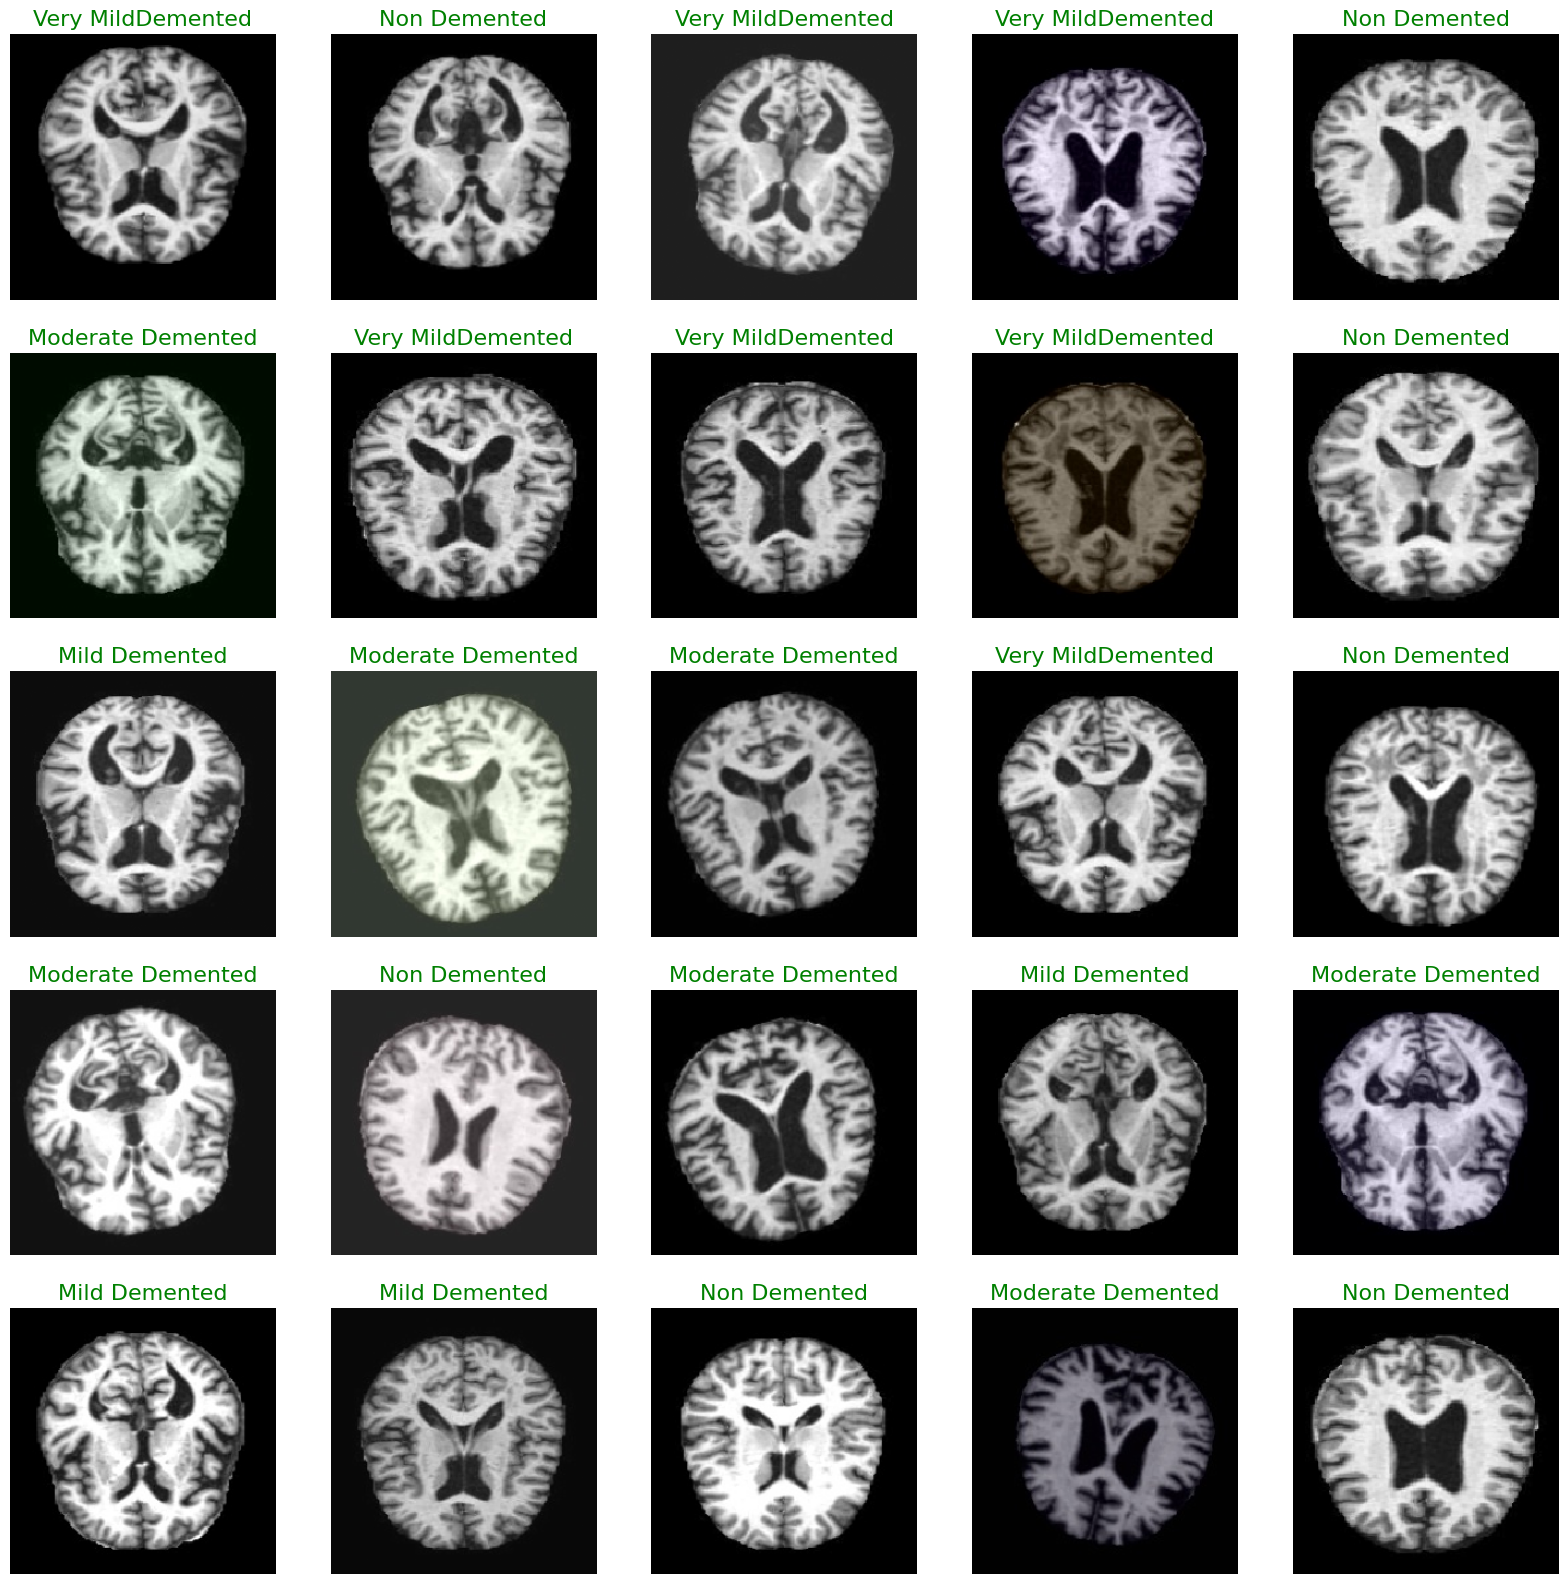

In [9]:
show_knee_images(train)

In [11]:
from tensorflow.keras.optimizers import Adamax

img_shape=(244,244,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False
    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [12]:
model.build(input_shape=(None, *img_shape))
tf.keras.utils.plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [23]:
# Check if saved model exists and load it
import os
import json
from tensorflow.keras.optimizers import Adamax

model_path = "Augmented_Alzheimer_Model.h5"
epoch_tracker_path = "epoch_tracker.json"

# Set this to True if you want to train even when model exists
# Set this to False if you want to skip training and just use the loaded model
CONTINUE_TRAINING = True  # Change to False to skip training

# Load epoch tracker
if os.path.exists(epoch_tracker_path):
    with open(epoch_tracker_path, 'r') as f:
        epoch_data = json.load(f)
        last_epoch = epoch_data.get('last_epoch', 0)
else:
    last_epoch = 0

if os.path.exists(model_path):
    print(f"Loading existing model from {model_path}...")
    model = tf.keras.models.load_model(model_path, compile=False)
    print("Model loaded successfully!")
    print(f"📊 Total epochs completed so far: {last_epoch-1}")
    
    # Always recompile with fresh optimizer
    model.compile(Adamax(learning_rate= 0.001),
                 loss= 'categorical_crossentropy',
                 metrics= ['accuracy'])
    print("Model recompiled with fresh optimizer.")
    
    if CONTINUE_TRAINING:
        print(f"✓ Training will continue from epoch {last_epoch}")
        model_loaded = False  # Allow training
    else:
        print("Will skip training and use loaded model.")
        model_loaded = True  # Skip training
else:
    print("No saved model found.")
    print("⚠️ Make sure to run cell 12 to build the model first!")
    last_epoch = 0
    model_loaded = False

Loading existing model from Augmented_Alzheimer_Model.h5...
Model loaded successfully!
📊 Total epochs completed so far: 3
Model recompiled with fresh optimizer.
✓ Training will continue from epoch 4


In [ ]:
# Custom callback to save model after each epoch AND every hour
import time
import json
from tensorflow.keras.callbacks import Callback

class AutoSaveCallback(Callback):
    def __init__(self, filepath, epoch_tracker_path, initial_epoch=0, hourly_interval=3600):
        super().__init__()
        self.filepath = filepath
        self.epoch_tracker_path = epoch_tracker_path
        self.initial_epoch = initial_epoch
        self.hourly_interval = hourly_interval  # seconds (3600 = 1 hour)
        self.last_save_time = time.time()
        self.epochs_trained = 0
    
    def on_epoch_end(self, epoch, logs=None):
        self.epochs_trained += 1
        self.model.save(self.filepath)
        # Save epoch tracker - epoch is already the absolute epoch number (0-indexed)
        session_epoch = epoch - self.initial_epoch + 1
        with open(self.epoch_tracker_path, 'w') as f:
            json.dump({'last_epoch': session_epoch}, f)
        print(f"\n✓ Model saved before epoch {session_epoch + 1} (session epoch {session_epoch})")
        self.last_save_time = time.time()
    
    def on_batch_end(self, batch, logs=None):
        # Check if an hour has passed during the epoch
        current_time = time.time()
        if current_time - self.last_save_time >= self.hourly_interval:
            self.model.save(self.filepath)
            hours_elapsed = (current_time - self.last_save_time) / 3600
            print(f"\n✓ Hourly checkpoint - Model saved ({hours_elapsed:.1f}h elapsed)")
            self.last_save_time = current_time
    
    def on_train_end(self, logs=None):
        # Only save and print message if epochs were actually trained
        if self.epochs_trained > 0:
            self.model.save(self.filepath)
            print("\n✓ Model saved at training completion")

auto_checkpoint = AutoSaveCallback("Augmented_Alzheimer_Model.h5", "epoch_tracker.json", 
                                   initial_epoch=last_epoch, hourly_interval=3600)

In [ ]:
# Training configuration
TOTAL_EPOCHS = 10  # Change this to set how many total epochs you want

# Only train if model wasn't loaded from file
if not model_loaded:
    try:
        # Train from last_epoch to TOTAL_EPOCHS
        if last_epoch >= TOTAL_EPOCHS:
            print(f"Already completed {last_epoch} epochs. Target is {TOTAL_EPOCHS}. No more training needed.")
            history = None
        else:
            print(f"Training from epoch {last_epoch} to {TOTAL_EPOCHS}...")
            history = model.fit(train, epochs=TOTAL_EPOCHS, initial_epoch=last_epoch-1, validation_data=val, 
                               validation_freq=1, callbacks=[auto_checkpoint])
            print("Training completed successfully!")
    except KeyboardInterrupt:
        print("\n⚠ Training interrupted by user!")
        model.save("Augmented_Alzheimer_Model.h5")
        print("✓ Model saved after interruption")
        raise
else:
    print("Skipping training - using loaded model")
    history = None

Training from epoch 4 to 10...
Epoch 4/10
307/850 ━━━━━━━━━━━━━━━━━━━━ 1:45:11 12s/step - accuracy: 0.9799 - loss: 0.0681


✓ Hourly checkpoint - Model saved (1.0h elapsed)
626/850 ━━━━━━━━━━━━━━━━━━━━ 42:48 11s/step - accuracy: 0.9843 - loss: 0.0549


✓ Hourly checkpoint - Model saved (1.0h elapsed)
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9861 - loss: 0.0494 


✓ Model saved before epoch 4 (session epoch 0)
850/850 ━━━━━━━━━━━━━━━━━━━━ 10292s 12s/step - accuracy: 0.9921 - loss: 0.0305 - val_accuracy: 0.9787 - val_loss: 0.0730
Epoch 5/10
318/850 ━━━━━━━━━━━━━━━━━━━━ 1:40:03 11s/step - accuracy: 0.9984 - loss: 0.0064


✓ Hourly checkpoint - Model saved (1.0h elapsed)
638/850 ━━━━━━━━━━━━━━━━━━━━ 39:50 11s/step - accuracy: 0.9974 - loss: 0.0097


✓ Hourly checkpoint - Model saved (1.0h elapsed)
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9972 - loss: 0.0102 


✓ Model saved before epoch 5 (session epoch 1)
850/850 ━━━━━━━━━━━━━━━━━━━━ 10067s 12s/step - accuracy: 0.9967 - loss: 0.0118 - val_accuracy: 0.9937 - val_loss: 0.0232
Epoch 6/10
320/850 ━━━━━━━━━━━━━━━━━━━━ 1:39:13 11s/step - accuracy: 0.9987 - loss: 0.0036


✓ Hourly checkpoint - Model saved (1.0h elapsed)
641/850 ━━━━━━━━━━━━━━━━━━━━ 39:08 11s/step - accuracy: 0.9984 - loss: 0.0047


✓ Hourly checkpoint - Model saved (1.0h elapsed)
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9983 - loss: 0.0051 


✓ Model saved before epoch 6 (session epoch 2)
850/850 ━━━━━━━━━━━━━━━━━━━━ 10051s 12s/step - accuracy: 0.9977 - loss: 0.0071 - val_accuracy: 0.9862 - val_loss: 0.0476
Epoch 7/10
226/850 ━━━━━━━━━━━━━━━━━━━━ 1:59:00 11s/step - accuracy: 0.9962 - loss: 0.0120

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
# Manual save (already saved during training, but can run this to save again)
model.save("Augmented_Alzheimer_Model.h5")
print("Model saved manually!")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

  3/319 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step

W0000 00:00:1709144499.903392     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


319/319 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step


In [ ]:
# Plot accuracy - only if model was trained in this session
if history is not None:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
else:
    print("Skipping plot - no training history available (model was loaded from file)")

In [ ]:
# Plot loss - only if model was trained in this session
if history is not None:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
else:
    print("Skipping plot - no training history available (model was loaded from file)")

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()